# Time Series Forecasting – ML Approach Part 1

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

## ARIMA

### Data Set

In [7]:
url1 = ('https://raw.githubusercontent.com/OrangeAVA/Mastering-Time-Series-Analysis-and-Forecasting-with-Python/refs/heads/main/ProductSalesData.csv')

df = pd.read_csv(url1)

df.drop(columns = ['Unnamed: 0'], inplace = True)

df.head()

,Date,Stock Level,Discount,Promotion,Units Sold
0,2010-01-01,2381.0,8.506768,Yes,59.0
1,2010-01-02,3252.0,9.283937,No,203.0
2,2010-01-03,2883.0,9.548446,No,33.0
3,2010-01-04,3586.0,9.660054,Yes,117.0
4,2010-01-05,3578.0,9.086065,No,71.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5041 entries, 0 to 5040
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5041 non-null   object 
 1   Stock Level  5041 non-null   float64
 2   Discount     5041 non-null   float64
 3   Promotion    5041 non-null   object 
 4   Units Sold   5041 non-null   float64
dtypes: float64(3), object(2)
memory usage: 197.0+ KB


### Data Preparation

In [10]:
df['Date'] = pd.to_datetime(df['Date'])  

df.set_index('Date', inplace=True)

df.head()

,Stock Level,Discount,Promotion,Units Sold
Date,,,,
2010-01-01,2381.0,8.506768,Yes,59.0
2010-01-02,3252.0,9.283937,No,203.0
2010-01-03,2883.0,9.548446,No,33.0
2010-01-04,3586.0,9.660054,Yes,117.0
2010-01-05,3578.0,9.086065,No,71.0


### Split Training and Test

In [12]:
train_size = int(len(df) * 0.8)

train, test = df[0:train_size], df[train_size:len(df)]

### ADF Test

In [14]:
# Augmented Dickey Fuller's test
ADF_result = adfuller(train['Units Sold'].dropna())

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print()

if ADF_result[1] > 0.05:        # p-value > alpha
    print('H0: Not Stationary')
else:                           # p-value < alpha
    print('Ha: Stationary')

ADF Statistic: -2.9726277800636662
p-value: 0.03753090042379054

Ha: Stationary


### Defining Parameters (p,q)

In [16]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,d,q) combinations
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) # Fit an ARMA(p,d,q) model using SARIMAX
        except:
            continue
            
        aic = model.aic                   # Calculate the model’s AIC.
        results.append([order, aic])      # Append the (p,q) combination and AIC as a tuple to the results list
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
from itertools import product

ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}
d = 0                               # Number of derivatives until Stationy

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

### Fit all unique ARIMA(p,d,q) models to extract the AIC values

In [19]:
from tqdm import tqdm_notebook

train_series = train['Units Sold']       # Convert dataframe train to a Pandas Series

train_series = train_series.asfreq('D')  # Set daily frequency ('D' for daily data)

# Run Function optimize_ARIMA
result_df = optimize_ARIMA(train_series, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",52292.790054
1,"(2, 1)",52294.577210
2,"(2, 2)",52295.023387
3,"(1, 2)",52295.363912
4,"(3, 2)",52297.040584
5,"(1, 3)",52298.044632
6,"(3, 1)",52298.692308
7,"(3, 3)",52299.196345
8,"(2, 3)",52301.790358
9,"(3, 0)",53333.939546


In [20]:
# Create the model with p=1, d=0, and q=1
model = ARIMA(train['Units Sold'], order=(1, 0, 1), freq = 'D')

# Fit the model
model_fit = model.fit()

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
# Generates out-of-sample predictions for the length of the test set
forecast = model_fit.forecast(steps=len(test))

forecast.head

<bound method NDFrame.head of 2021-01-15    395.895110
2021-01-16    395.871473
2021-01-17    395.847846
2021-01-18    395.824230
2021-01-19    395.800625
                 ...    
2023-10-16    376.841420
2023-10-17    376.826452
2023-10-18    376.811492
2023-10-19    376.796538
2023-10-20    376.781591
Freq: D, Name: predicted_mean, Length: 1009, dtype: float64>

In [22]:
# Error Measures
mse = mean_squared_error(test['Units Sold'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Units Sold'], forecast)

print('     Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('    Mean Absolute Error:', mae)

     Mean Squared Error: 47972.72536812223
Root Mean Squared Error: 219.02676861087602
    Mean Absolute Error: 189.53435416488236


In [23]:
train.head()

,Stock Level,Discount,Promotion,Units Sold
Date,,,,
2010-01-01,2381.0,8.506768,Yes,59.0
2010-01-02,3252.0,9.283937,No,203.0
2010-01-03,2883.0,9.548446,No,33.0
2010-01-04,3586.0,9.660054,Yes,117.0
2010-01-05,3578.0,9.086065,No,71.0


In [24]:
test.tail()

,Stock Level,Discount,Promotion,Units Sold
Date,,,,
2023-10-16,2914.0,9.348578,No,40.0
2023-10-17,2004.0,9.145434,Yes,147.0
2023-10-18,2505.0,9.349116,Yes,231.0
2023-10-19,2276.0,9.534400,No,122.0
2023-10-20,2814.0,9.553762,No,141.0


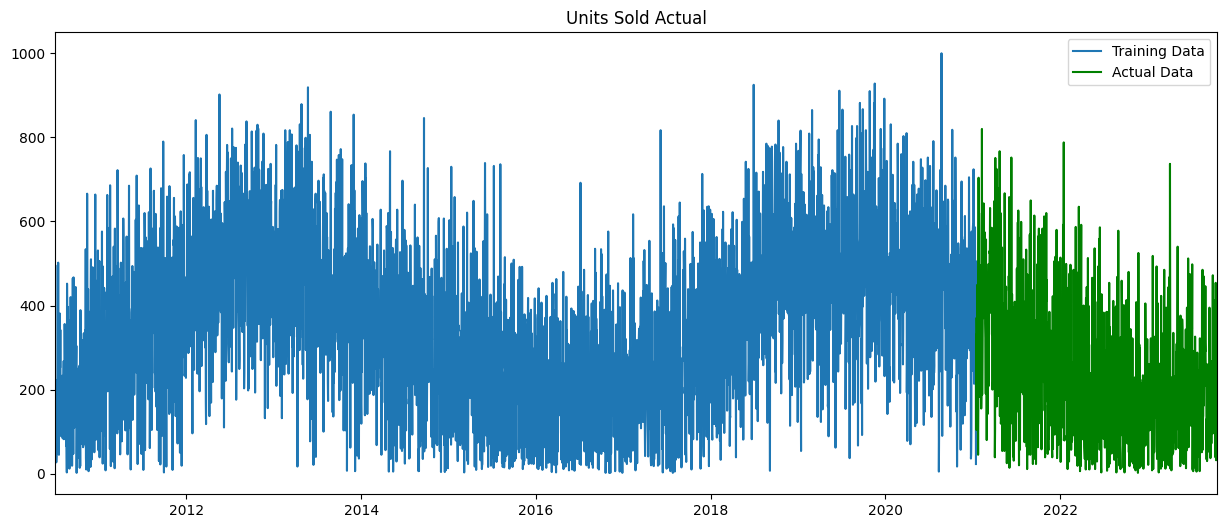

In [25]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train['Units Sold'], label='Training Data')
ax.plot(test['Units Sold'], label='Actual Data', color='green')

ax.set_title('Units Sold Actual')

ax.set_xlim(pd.Timestamp('2010-07-01'), pd.Timestamp('2023-10-20')) 

ax.legend()
plt.show()


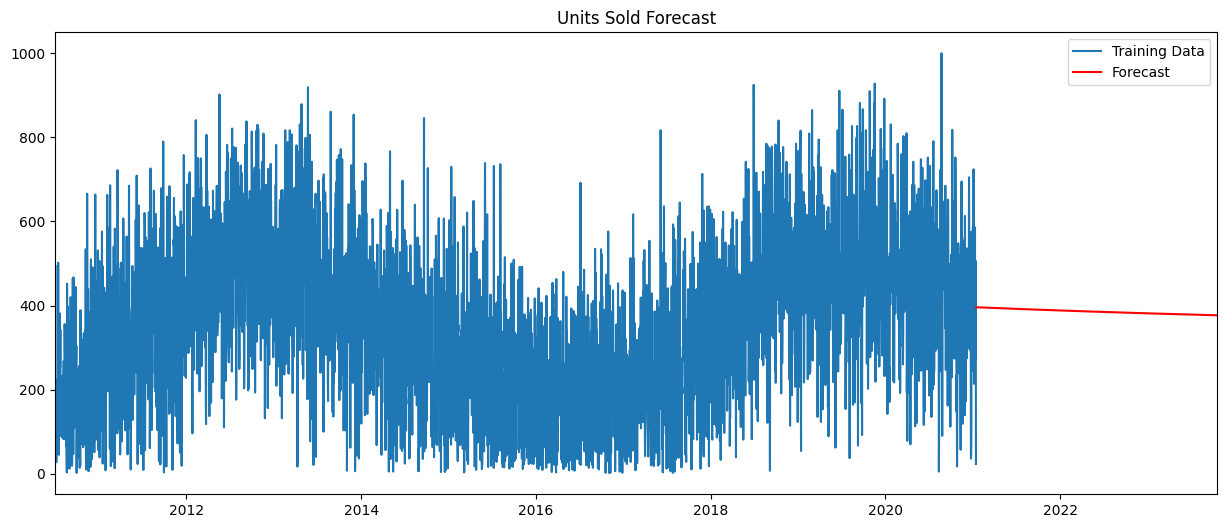

In [26]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train['Units Sold'], label='Training Data')
ax.plot(test.index, forecast, label='Forecast', color='red')

ax.set_title('Units Sold Forecast')

ax.set_xlim(pd.Timestamp('2010-07-01'), pd.Timestamp('2023-10-20')) 

ax.legend()
plt.show()

## Exponential smoothing models

### Single Exponential Smoothing

In [29]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model2 = SimpleExpSmoothing(train['Units Sold'])

model_fit2 = model2.fit()

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:
forecast2 = model_fit2.forecast(steps=len(test))

mse2 = mean_squared_error(test['Units Sold'], forecast2)
rmse2 = np.sqrt(mse)
mae2 = mean_absolute_error(test['Units Sold'], forecast2)

print('     Mean Squared Error:', mse2)
print('Root Mean Squared Error:', rmse2)
print('    Mean Absolute Error:', mae2)

     Mean Squared Error: 51957.80676254057
Root Mean Squared Error: 219.02676861087602
    Mean Absolute Error: 197.73015624567273


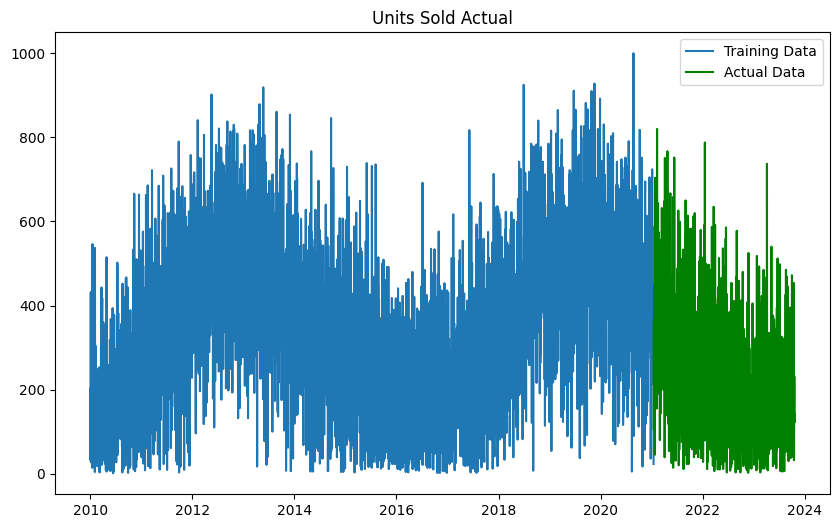

In [31]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test['Units Sold'], label='Actual Data', color='green')
plt.title('Units Sold Actual')
plt.legend()
plt.show()

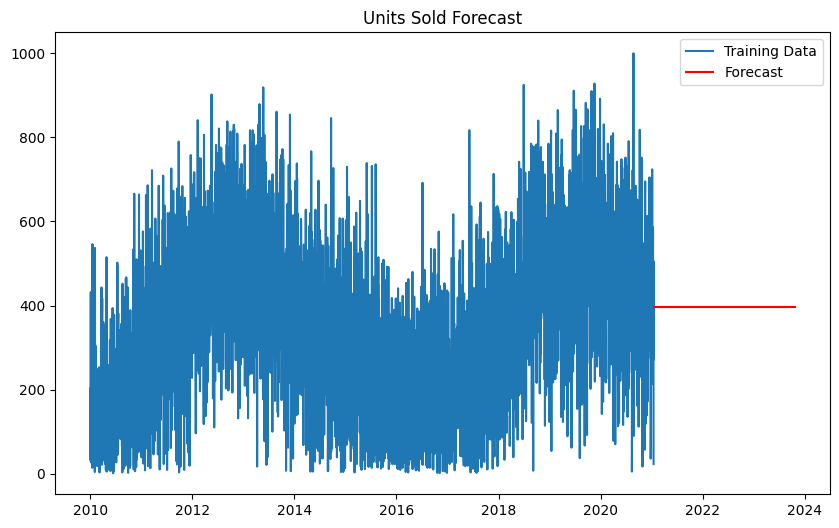

In [32]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test.index, forecast2, label='Forecast', color='red')
plt.title('Units Sold Forecast')
plt.legend()
plt.show()

## Double Exponential Smoothing

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_db = ExponentialSmoothing(train['Units Sold'], trend='add')

model_fit_db = model_db.fit()

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [35]:
forecast_db = model_fit_db.forecast(steps=len(test))

msedb = mean_squared_error(test['Units Sold'], forecast_db)
rmsedb = np.sqrt(mse)
maedb = mean_absolute_error(test['Units Sold'], forecast_db)

print('     Mean Squared Error:', msedb)
print('Root Mean Squared Error:', rmsedb)
print('    Mean Absolute Error:', maedb)

     Mean Squared Error: 24895.570013418586
Root Mean Squared Error: 219.02676861087602
    Mean Absolute Error: 126.78737028565025


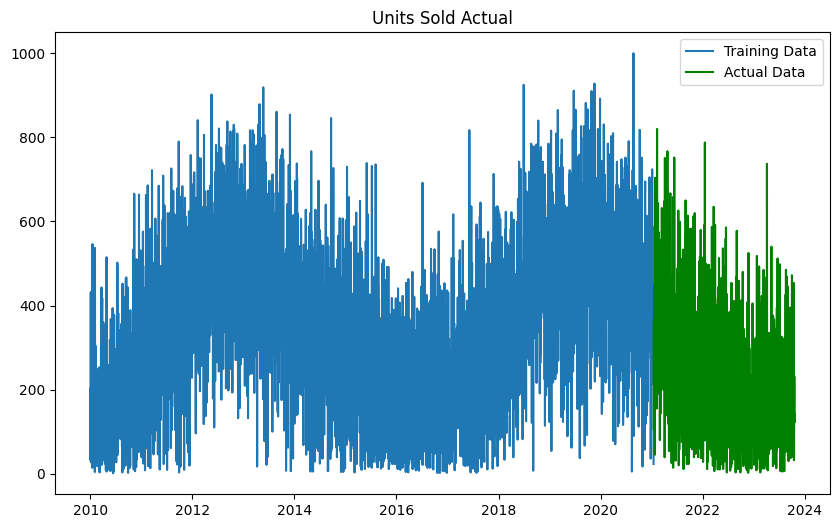

In [36]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test['Units Sold'], label='Actual Data', color='green')
plt.title('Units Sold Actual')
plt.legend()
plt.show()

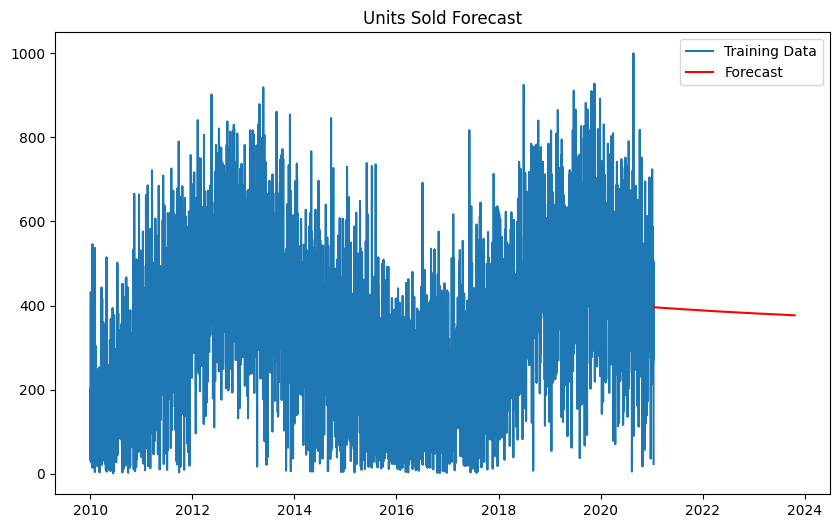

In [37]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Units Sold Forecast')
plt.legend()
plt.show()

### Triple Exponential Smoothing

In [39]:
model3 = ExponentialSmoothing(train['Units Sold'], trend='add', seasonal='add', seasonal_periods=12)

model_fit3 = model3.fit()

C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lsoares\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [40]:
forecast3 = model_fit3.forecast(steps=len(test))

mse3 = mean_squared_error(test['Units Sold'], forecast3)
rmse3 = np.sqrt(mse)
mae3 = mean_absolute_error(test['Units Sold'], forecast3)

print('     Mean Squared Error:', mse3)
print('Root Mean Squared Error:', rmse3)
print('    Mean Absolute Error:', mae3)

     Mean Squared Error: 27029.23067108965
Root Mean Squared Error: 219.02676861087602
    Mean Absolute Error: 130.90637558124791


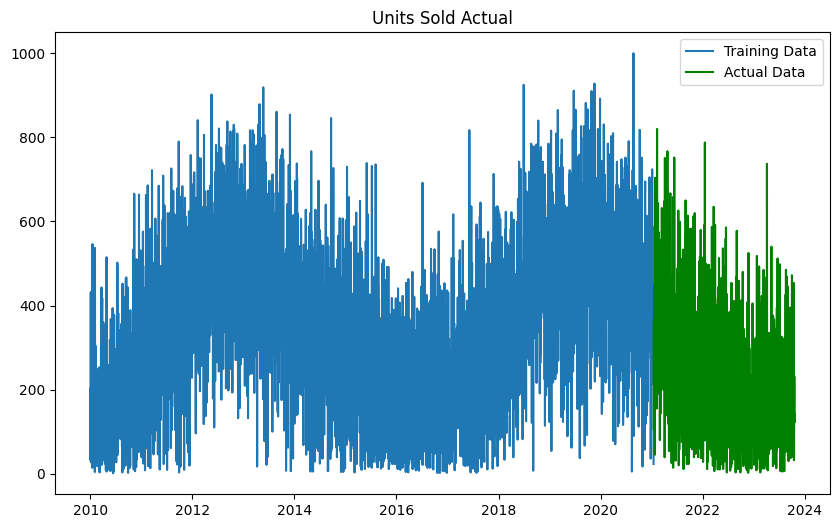

In [41]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test['Units Sold'], label='Actual Data', color='green')
plt.title('Units Sold Actual')
plt.legend()
plt.show()

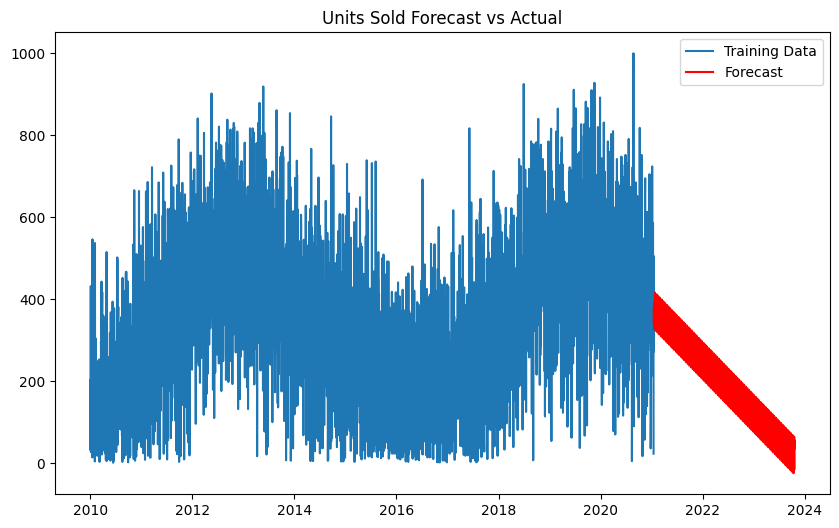

In [42]:
plt.figure(figsize=(10,6))
plt.plot(train['Units Sold'], label='Training Data')
plt.plot(test.index, forecast3, label='Forecast', color='red')
plt.title('Units Sold Forecast vs Actual')
plt.legend()
plt.show()

## Prophet

In [44]:
from prophet import Prophet

In [45]:
df = pd.read_csv(url1)

df.drop(columns = ['Unnamed: 0'], inplace = True)

df.head()

,Date,Stock Level,Discount,Promotion,Units Sold
0,2010-01-01,2381.0,8.506768,Yes,59.0
1,2010-01-02,3252.0,9.283937,No,203.0
2,2010-01-03,2883.0,9.548446,No,33.0
3,2010-01-04,3586.0,9.660054,Yes,117.0
4,2010-01-05,3578.0,9.086065,No,71.0


In [46]:
df = df.rename(columns={'Date': 'ds', 'Units Sold': 'y'})

df['ds'] = pd.to_datetime(df['ds'])

df.head()

,ds,Stock Level,Discount,Promotion,y
0,2010-01-01,2381.0,8.506768,Yes,59.0
1,2010-01-02,3252.0,9.283937,No,203.0
2,2010-01-03,2883.0,9.548446,No,33.0
3,2010-01-04,3586.0,9.660054,Yes,117.0
4,2010-01-05,3578.0,9.086065,No,71.0


In [47]:
df.drop(columns = ['Stock Level', 'Discount', 'Promotion'], inplace = True)

df.head()

,ds,y
0,2010-01-01,59.0
1,2010-01-02,203.0
2,2010-01-03,33.0
3,2010-01-04,117.0
4,2010-01-05,71.0


In [48]:
# Create instance
model = Prophet()

# Fit the model with 'df'
model.fit(df)

11:04:42 - cmdstanpy - INFO - Chain [1] start processing
11:04:42 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
# Generates future timestamps for 60 periods ahead
df_future = model.make_future_dataframe(periods=60)  

df_future.head(5)

,ds
0,2010-01-01
1,2010-01-02
2,2010-01-03
3,2010-01-04
4,2010-01-05


In [50]:
forecast = model.predict(df_future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,113.800000,-90.513340,328.943601,113.800000,113.800000,2.658516,2.658516,2.658516,1.158114,1.158114,1.158114,1.500402,1.500402,1.500402,0.0,0.0,0.0,116.458516
1,2010-01-02,114.219831,-71.147785,322.855723,114.219831,114.219831,0.053461,0.053461,0.053461,-1.509104,-1.509104,-1.509104,1.562565,1.562565,1.562565,0.0,0.0,0.0,114.273293
2,2010-01-03,114.639663,-78.092446,322.170276,114.639663,114.639663,8.172149,8.172149,8.172149,6.746922,6.746922,6.746922,1.425227,1.425227,1.425227,0.0,0.0,0.0,122.811812
3,2010-01-04,115.059494,-85.016399,308.532373,115.059494,115.059494,-0.163557,-0.163557,-0.163557,-1.263498,-1.263498,-1.263498,1.099941,1.099941,1.099941,0.0,0.0,0.0,114.895937
4,2010-01-05,115.479325,-79.706404,307.002835,115.479325,115.479325,5.167642,5.167642,5.167642,4.564437,4.564437,4.564437,0.603205,0.603205,0.603205,0.0,0.0,0.0,120.646967


In [51]:
forecast.tail(5).transpose()

,5096,5097,5098,5099,5100
ds,2023-12-15 00:00:00,2023-12-16 00:00:00,2023-12-17 00:00:00,2023-12-18 00:00:00,2023-12-19 00:00:00
trend,104.361631,104.10961,103.857589,103.605568,103.353547
yhat_lower,-108.108668,-107.043361,-97.833805,-116.539054,-93.147434
yhat_upper,292.326612,271.925379,298.013353,287.198251,306.474123
trend_lower,104.190292,103.908236,103.634601,103.350115,103.065559
trend_upper,104.694289,104.493836,104.259795,104.047807,103.822807
additive_terms,-16.790932,-18.742588,-9.566462,-16.475596,-9.392648
additive_terms_lower,-16.790932,-18.742588,-9.566462,-16.475596,-9.392648
additive_terms_upper,-16.790932,-18.742588,-9.566462,-16.475596,-9.392648
weekly,1.158114,-1.509104,6.746922,-1.263498,4.564437


In [52]:
y_pred = forecast['yhat'][-60:]  # Extracts the last 60 predicted values from the forecast

y_true = df['y'][-60:]           # Extracts the last 60 actual values from the original dataset

In [53]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print('     Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('    Mean Absolute Error:', mae)

     Mean Squared Error: 25133.189856371784
Root Mean Squared Error: 158.53450683170456
    Mean Absolute Error: 124.05051459945842


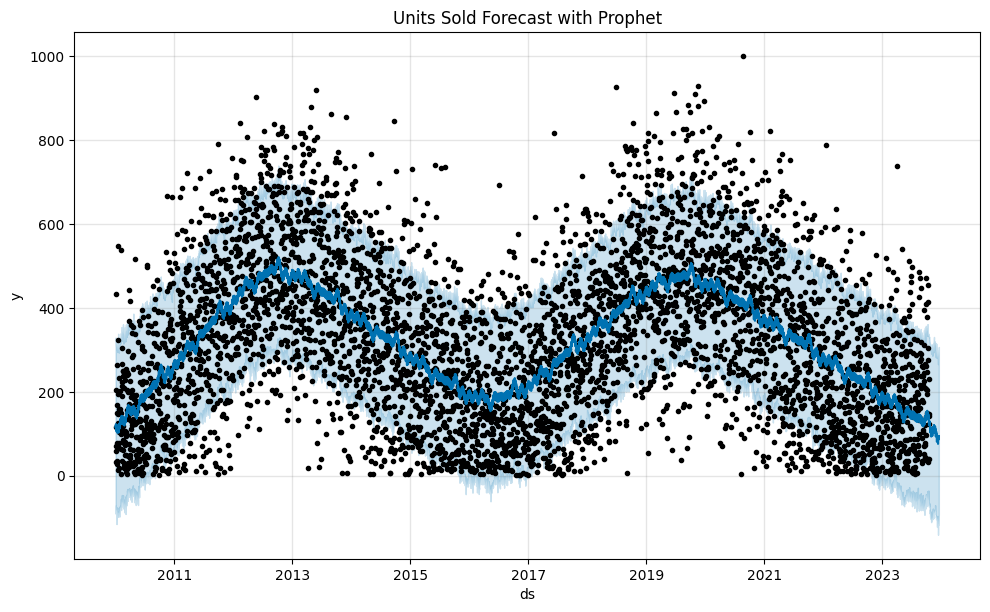

In [65]:
fig = model.plot(forecast)
plt.title('Units Sold Forecast with Prophet')
plt.show()